<a href="https://colab.research.google.com/github/Rupal-02/BlinkIt-vs-Zepto-vs-JioMart-Review-Analysis/blob/main/LSTM_Sentiment_Analysis_on_Blinkit_Zepto_Jiomart_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM Sentiment Analysis on Blinkit Zepto Jiomart Reviews

This Colab notebook performs sentiment analysis on e-commerce reviews using a Long Short-Term Memory (LSTM) model. The notebook focuses on reviews from three specific platforms: Zepto, Jiomart, and Blinkit.

It covers data loading, preprocessing, model building, training, evaluation, and prediction. The notebook demonstrates a practical application of deep learning for sentiment classification in the e-commerce domain.

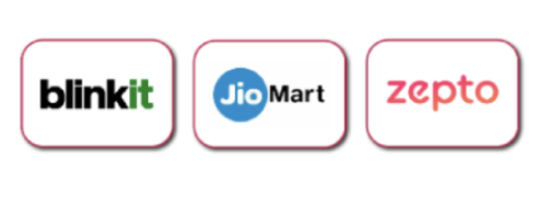

**Preliminary EDA**


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving reviews.csv to reviews.csv


In [ ]:
# Load the dataset
data = pd.read_csv('reviews.csv')

In [ ]:
# Display basic information
print("Shape of the dataset:", data.shape)  # (rows, columns)
print("\nData types of each column:\n", data.dtypes)
print("\nFirst few rows of the dataset:\n", data.head())
print("\nSummary statistics:\n", data.describe(include='all'))


Shape of the dataset: (4620, 4)

Data types of each column:
 rating       int64
date        object
review      object
platform    object
dtype: object

First few rows of the dataset:
    rating              date  \
0       2  30 December 2024   
1       1   4 November 2024   
2       1   31 October 2024   
3       5    29 August 2024   
4       2  31 December 2024   

                                              review platform  
0  I was using it for long time, but have to stop...  blinkit  
1  Loving the fast deliveries and mostly they are...  blinkit  
2  The customer support is very disappointing. I ...  blinkit  
3  I've been using Blinkit for a while now, and i...  blinkit  
4  Blinkit was my go to app and it was rare that ...  blinkit  

Summary statistics:
              rating              date  \
count   4620.000000              4620   
unique          NaN               329   
top             NaN  24 December 2024   
freq            NaN               138   
mean       1.82727

In [ ]:
# Check for missing values
print("\nMissing values in each column:\n", data.isnull().sum())


Missing values in each column:
 rating      0
date        0
review      0
platform    0
dtype: int64


In [ ]:
# Explore unique values in categorical columns
for column in data.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in '{column}' column:\n", data[column].unique())
    print(f"Number of unique values: {data[column].nunique()}")


Unique values in 'date' column:
 ['30 December 2024' '4 November 2024' '31 October 2024' '29 August 2024'
 '31 December 2024' '28 December 2024' '29 December 2024'
 '17 December 2024' '25 December 2024' '27 December 2024'
 '21 December 2024' '16 December 2024' '26 December 2024'
 '11 December 2024' '19 December 2024' '24 December 2024'
 '22 December 2024' '23 December 2024' '19 October 2024'
 '13 December 2024' '20 December 2024' '23 October 2024'
 '18 December 2024' '30 October 2024' '15 December 2024' '5 November 2024'
 '2 December 2024' '14 December 2024' '12 December 2024' '18 October 2024'
 '9 December 2024' '4 December 2024' '3 December 2024' '8 December 2024'
 '10 December 2024' '6 December 2024' '5 December 2024' '10 November 2024'
 '25 October 2024' '19 November 2024' '15 October 2024' '21 October 2024'
 '20 October 2024' '7 November 2024' '16 October 2024' '11 November 2024'
 '30 November 2024' '1 December 2024' '9 November 2024' '14 November 2024'
 '15 November 2024' '26 Oc

array([[<Axes: title={'center': 'rating'}>]], dtype=object)

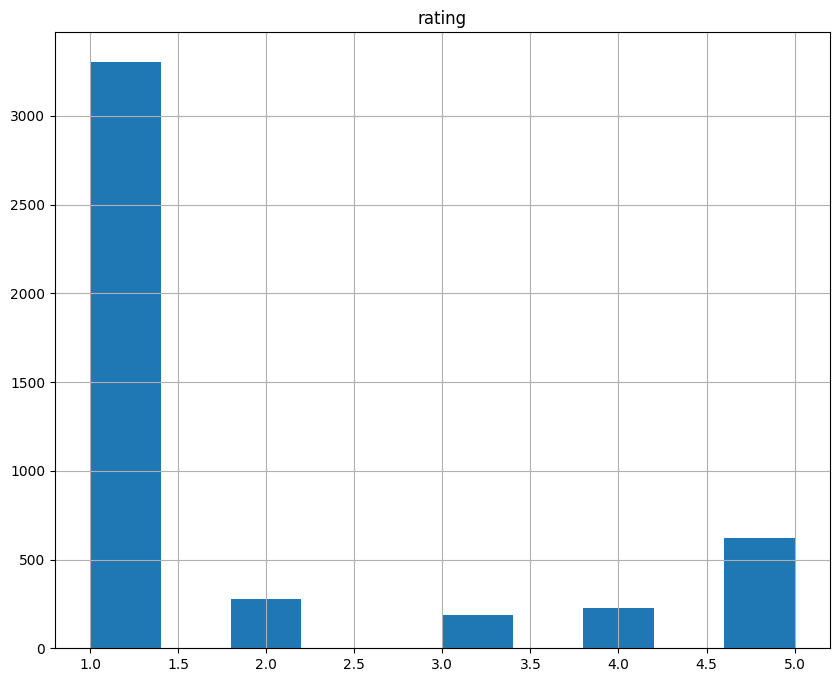

In [ ]:
#Distribution of numerical features
data.hist(figsize=(10, 8))

# LSTM Sentiment Analysis on E-Commerce Reviews (Zepto vs Jiomart vs Blinkit)

## Imports

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.callbacks import EarlyStopping
import plotly.graph_objects as go
from sklearn.metrics import classification_report


## Pre Processing

In [ ]:
data['rating_label'] = data['rating'].apply(lambda x: 'positive' if x >= 4 else 'neutral' if x == 3 else 'negative')
data

,rating,date,review,platform,rating_label
0,2,30 December 2024,"I was using it for long time, but have to stop...",blinkit,negative
1,1,4 November 2024,Loving the fast deliveries and mostly they are...,blinkit,negative
2,1,31 October 2024,The customer support is very disappointing. I ...,blinkit,negative
3,5,29 August 2024,"I've been using Blinkit for a while now, and i...",blinkit,positive
4,2,31 December 2024,Blinkit was my go to app and it was rare that ...,blinkit,negative
...,...,...,...,...,...
4615,1,27 November 2024,I have deposited ₹1300 to my zepto wallet to o...,zepto,negative
4616,4,5 December 2024,Prices r competitive for certain items. Not fo...,zepto,positive
4617,1,13 November 2024,Worst delivery ever. They delivered a broken p...,zepto,negative
4618,5,17 November 2024,"I had a great experience with zepto, the quali...",zepto,positive


In [ ]:
label_encoder = LabelEncoder()

data['rating_label_encoded'] = label_encoder.fit_transform(data['rating_label'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nLabel Mapping:")
print(label_mapping)

num_classes = data['rating_label_encoded'].nunique()
print(f"\nNumber of classes: {num_classes}")


Label Mapping:
{'negative': 0, 'neutral': 1, 'positive': 2}

Number of classes: 3


## Tokenize and Pad Text Sequences

In [ ]:
# Initialize Tokenizer
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(data['review'].values)

# Convert texts to sequences
X = tokenizer.texts_to_sequences(data['review'].values)

# maximum sequence length
maxlen = 100

# Pad sequences to ensure uniform length
X = pad_sequences(X, maxlen=maxlen)

print(f"\nShape of X: {X.shape}")

# One-hot encode the target labels
y = pd.get_dummies(data['rating_label_encoded']).values

print(f"Shape of y: {y.shape}")



Shape of X: (4620, 100)
Shape of y: (4620, 3)


## Test Train Split

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: Validation and Test from Temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTraining set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (3234, 100), (3234, 3)
Validation set shape: (693, 100), (693, 3)
Test set shape: (693, 100), (693, 3)


## LSTM Model

In [ ]:

embed_dim = 128        # Embedding dimensions
lstm_out = 196         # LSTM units
max_features = len(tokenizer.word_index) + 1  # Vocabulary size (+1 for padding)

print(f"\nVocabulary Size: {max_features}")

model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embed_dim))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_classes, activation='softmax'))  # Adjusted for multi-class

print("\nModel Summary:")
print(model.summary())

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


Vocabulary Size: 8945

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

## Train

In [ ]:
batch_size = 64
epochs = 20  # Increased epochs with early stopping

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1)

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 443ms/step - accuracy: 0.7245 - loss: 0.8130 - val_accuracy: 0.7835 - val_loss: 0.5422
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 465ms/step - accuracy: 0.8277 - loss: 0.4655 - val_accuracy: 0.8918 - val_loss: 0.3397
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 514ms/step - accuracy: 0.9117 - loss: 0.2925 - val_accuracy: 0.8961 - val_loss: 0.3239
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 454ms/step - accuracy: 0.9315 - loss: 0.2122 - val_accuracy: 0.9076 - val_loss: 0.3090
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.9451 - loss: 0.1709 - val_accuracy: 0.8947 - val_loss: 0.3501
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 43s 459ms/step - accuracy: 0.9503 - loss: 0.1522 - val_accuracy: 0.8889 - val_loss: 0.4359
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 461ms/step - accuracy: 0.9482 - loss: 0.1546 - val_accuracy: 0.8903 - val_loss: 0.3621


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.2f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9079 - loss: 0.3394

Test Accuracy: 0.89


## Evaluation

In [ ]:
# Predict probabilities
y_pred = model.predict(X_test)

y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
              precision    recall  f1-score   support

    negative       0.92      0.97      0.94       537
     neutral       0.00      0.00      0.00        29
    positive       0.77      0.78      0.78       127

    accuracy                           0.89       693
   macro avg       0.56      0.58      0.57       693
weighted avg       0.85      0.89      0.87       693



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def plot_training_history(history):
    fig = go.Figure()

    # Plot Training Accuracy
    fig.add_trace(go.Scatter(
        x=list(range(1, len(history.history['accuracy']) + 1)),
        y=history.history['accuracy'],
        mode='lines+markers',
        name='Training Accuracy'
    ))

    # Plot Validation Accuracy
    fig.add_trace(go.Scatter(
        x=list(range(1, len(history.history['val_accuracy']) + 1)),
        y=history.history['val_accuracy'],
        mode='lines+markers',
        name='Validation Accuracy'
    ))

    # Plot Training Loss
    fig.add_trace(go.Scatter(
        x=list(range(1, len(history.history['loss']) + 1)),
        y=history.history['loss'],
        mode='lines+markers',
        name='Training Loss'
    ))

    # Plot Validation Loss
    fig.add_trace(go.Scatter(
        x=list(range(1, len(history.history['val_loss']) + 1)),
        y=history.history['val_loss'],
        mode='lines+markers',
        name='Validation Loss'
    ))

    fig.update_layout(
        title='Model Training History',
        xaxis_title='Epoch',
        yaxis_title='Metric Value',
        legend_title='Metrics',
        template='plotly_white'
    )

    fig.show()


plot_training_history(history)


## Prediction

In [ ]:
def predict_review(review, model, tokenizer, label_encoder, maxlen=100):
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)
    prediction = model.predict(padded_sequence)

    class_idx = prediction.argmax(axis=1)[0]
    label = label_encoder.inverse_transform([class_idx])[0]

    confidence = prediction[0][class_idx]

    return f"Sentiment: {label}, Confidence: {confidence:.2f}"

In [ ]:
example_review = "I love the fast delivery and great service!"
print(example_review)
print(f"{predict_review(example_review, model, tokenizer, label_encoder, maxlen)}\n")

example_review = "Terrible Service. Would not order"
print(example_review)
print(f"{predict_review(example_review, model, tokenizer, label_encoder, maxlen)}\n")

example_review = "App is okay."
print(example_review)
print(f"{predict_review(example_review, model, tokenizer, label_encoder, maxlen)}\n")

example_review = "Delivery can be faster."
print(example_review)
print(f"{predict_review(example_review, model, tokenizer, label_encoder, maxlen)}\n")

I love the fast delivery and great service!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Sentiment: positive, Confidence: 0.98

Terrible Service. Would not order
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Sentiment: negative, Confidence: 0.73

App is okay.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sentiment: neutral, Confidence: 0.54

Delivery can be faster.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Sentiment: positive, Confidence: 0.54



In [ ]:
example_review = "I love the fast delivery and great service!"
print(example_review)
print(f"{predict_review(example_review, model, tokenizer, label_encoder, maxlen)}\n")

example_review = "Terrible Service. Would not order"
print(example_review)
print(f"{predict_review(example_review, model, tokenizer, label_encoder, maxlen)}\n")

example_review = "App is okay."
print(example_review)
print(f"{predict_review(example_review, model, tokenizer, label_encoder, maxlen)}\n")

example_review = "Very pathetic and frustrating experience with blinkit."
print(example_review)
print(f"{predict_review(example_review, model, tokenizer, label_encoder, maxlen)}\n")

I love the fast delivery and great service!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Sentiment: positive, Confidence: 0.98

Terrible Service. Would not order
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Sentiment: negative, Confidence: 0.73

App is okay.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Sentiment: neutral, Confidence: 0.54

Very pathetic and frustrating experience with blinkit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Sentiment: negative, Confidence: 0.63

